In [1]:
import pandas as pd
import plotnine as gg 
import numpy as np
import scipy.stats as st
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, TargetEncoder, LabelEncoder
from sklearn.impute import SimpleImputer

from sklearn.ensemble import VotingClassifier
import xgboost as xgb
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

import joblib
from sklearn.cluster import KMeans


from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit, RepeatedStratifiedKFold
sedd = 11

In [2]:
train = pd.read_csv("train.csv")
train = train.drop_duplicates(keep = 'first').copy()
train.reset_index(inplace = True)
y = train.Exited.copy()
X = train.drop('Exited', axis = 1).copy()
test = pd.read_csv("test.csv")

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   index            165034 non-null  int64  
 1   id               165034 non-null  int64  
 2   CustomerId       165034 non-null  int64  
 3   Surname          165034 non-null  object 
 4   CreditScore      165034 non-null  int64  
 5   Geography        165034 non-null  object 
 6   Gender           165034 non-null  object 
 7   Age              165034 non-null  float64
 8   Tenure           165034 non-null  int64  
 9   Balance          165034 non-null  float64
 10  NumOfProducts    165034 non-null  int64  
 11  HasCrCard        165034 non-null  float64
 12  IsActiveMember   165034 non-null  float64
 13  EstimatedSalary  165034 non-null  float64
 14  Exited           165034 non-null  int64  
dtypes: float64(5), int64(7), object(3)
memory usage: 18.9+ MB


In [4]:
train.head(3)

,index,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.0,2,1.0,0.0,181449.97,0
1,1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.0,2,1.0,1.0,49503.50,0
2,2,2,15694510,Hsueh,678,France,Male,40.0,10,0.0,2,1.0,0.0,184866.69,0


In [5]:
train.shape

(165034, 15)

In [6]:
extended = pd.read_csv("extended/dataset_raw.csv")

In [7]:
extended.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,5,GOLD,350
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,5,GOLD,425


In [8]:
notes = {} 

Ratio of 0 to 1 is 3.72592422897397: 1 


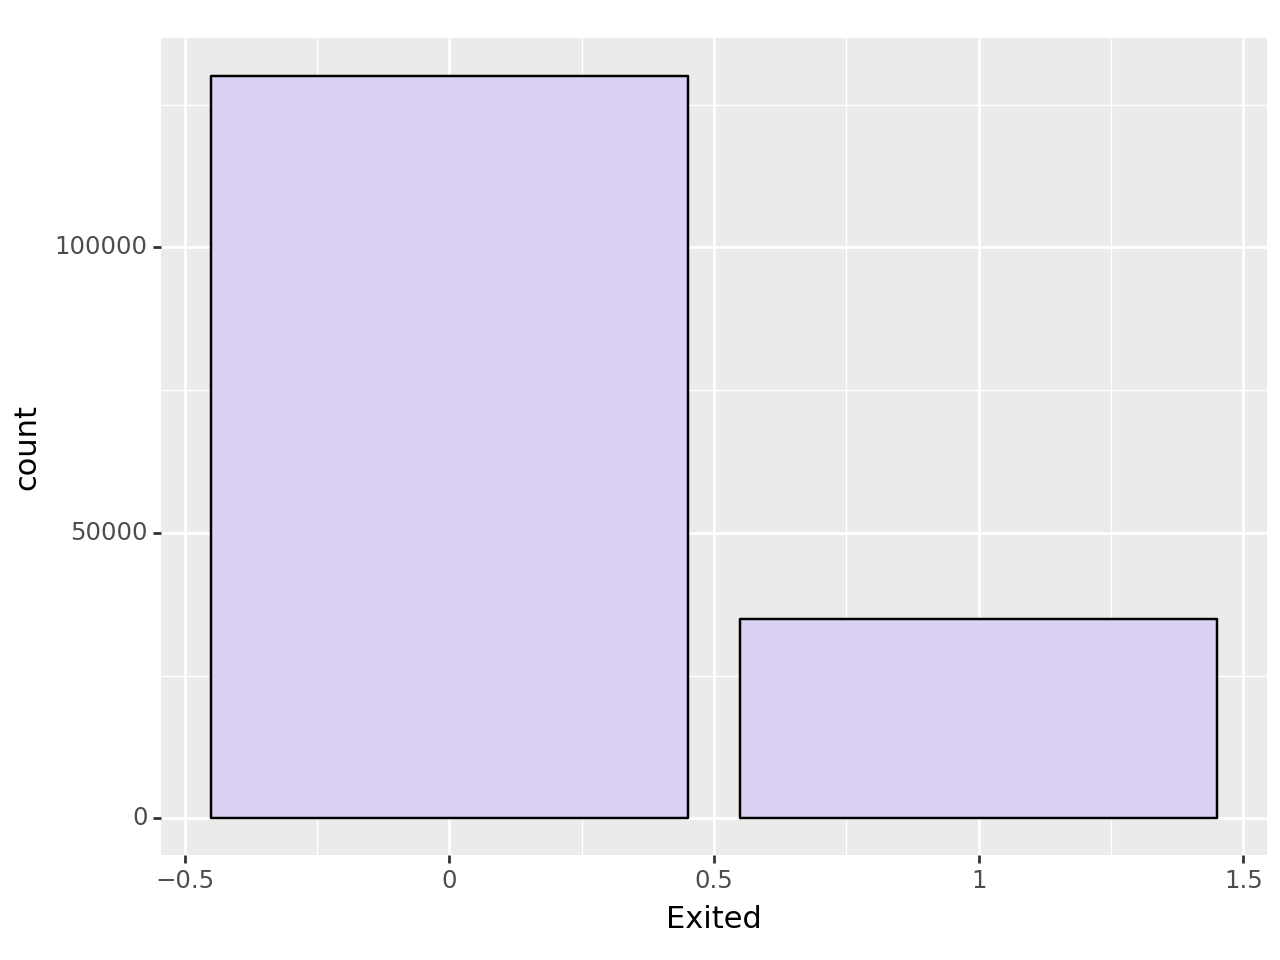

<Figure Size: (640 x 480)>

In [9]:
a = gg.ggplot(data = train, mapping = gg.aes(x= 'Exited')) + gg.geom_bar(fill = "#dbd1f4", color = "black",size = 0.5  )
#There are many 0s than 1. 
print("Ratio of 0 to 1 is {}: 1 ".format((train.shape[0] - train.Exited.sum() ) / (train.Exited.sum())))
#Use the ratio in optimizing XGBoost
notes[1] = "for exited, use the ratio in optimizing XGBoost"
a

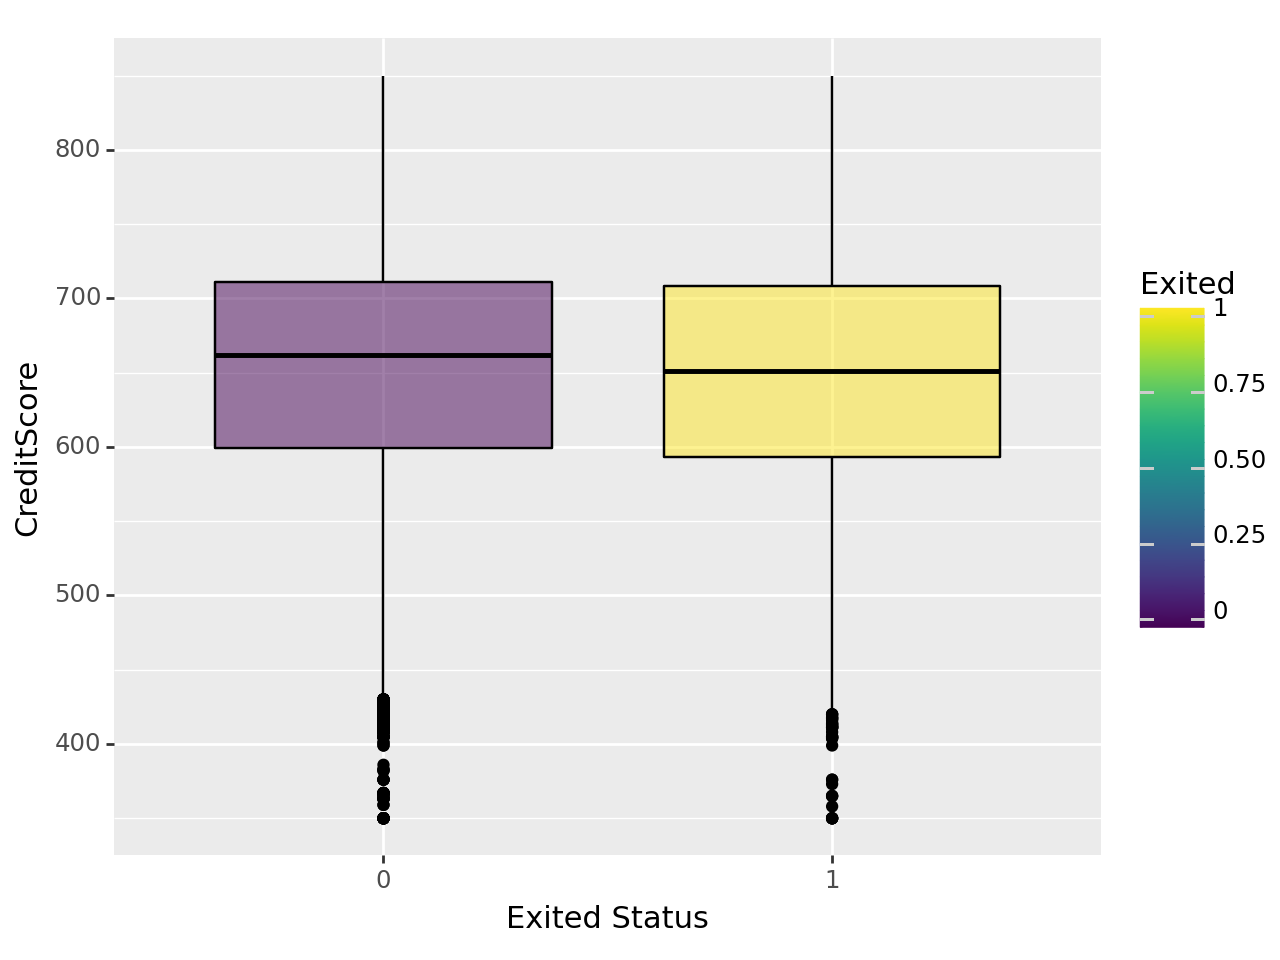

<Figure Size: (640 x 480)>

In [10]:
#Credit Score and Exited:
x_axis =train.Exited.apply(lambda x: "1" if(x == 1) else "0") 
b = gg.ggplot(data = train, mapping = gg.aes(x = x_axis, y = train.CreditScore, fill = train.Exited))
b += gg.geom_boxplot(color ='black', alpha = 0.5) 
b += gg.labs(x = "Exited Status")
# No difference in credit score. Drop credit score. 
notes[2] = "No difference in credit score. Drop credit score. "
b

Exited         0      1
Geography              
France     78643  15572
Germany    21492  13114
Spain      29978   6235


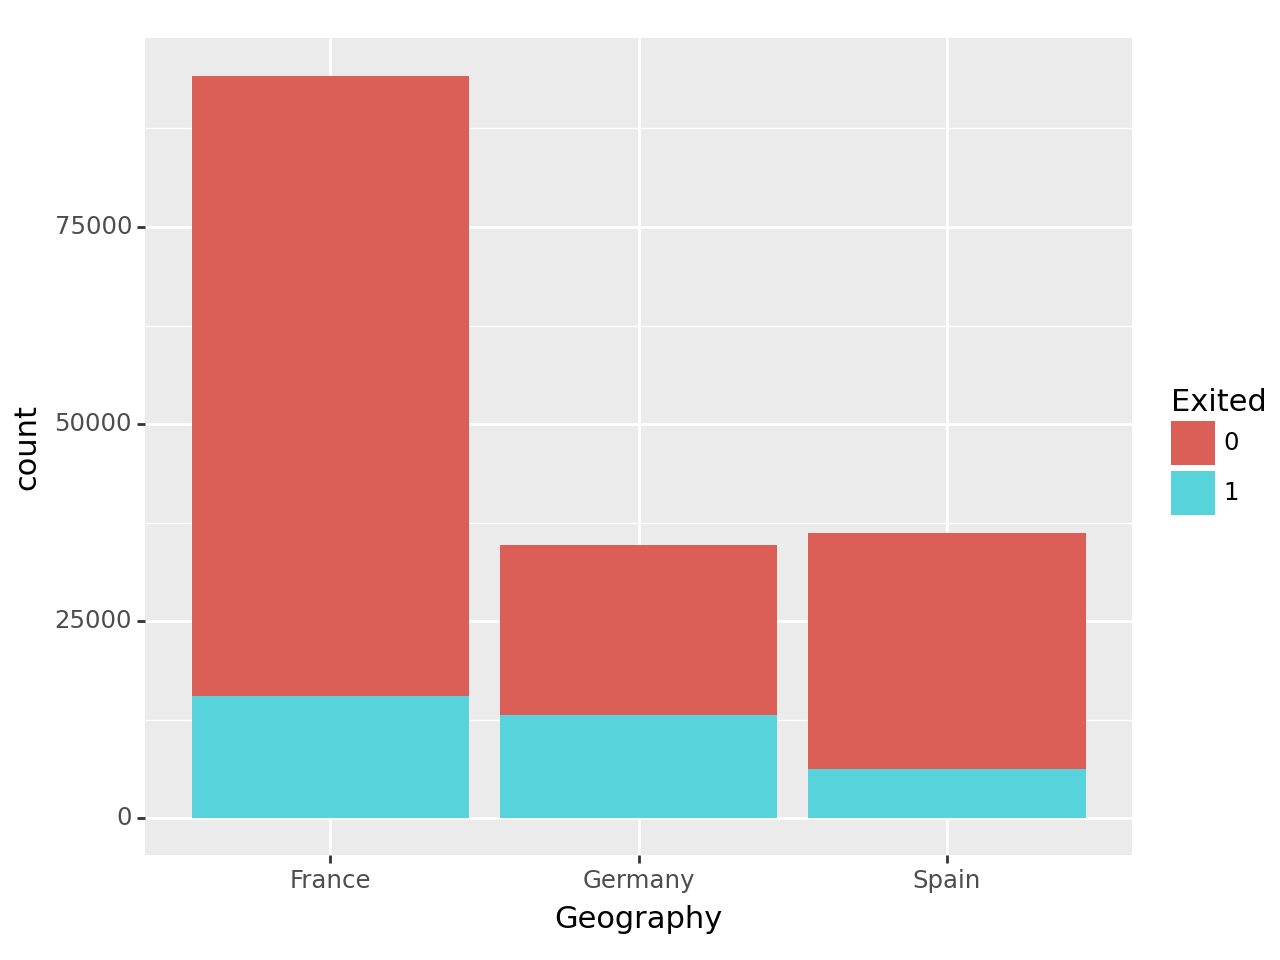

<Figure Size: (640 x 480)>

In [11]:
#Geography and Exited:
out = pd.crosstab(index = train.Geography, columns = train.Exited)
print(out)
y_target = train.Exited.apply(str)
c = gg.ggplot(data = train, mapping = gg.aes(x = train.Geography, fill = y_target))
c += gg.geom_bar()
# Use one hot encoder and remove the one variable 
notes [3] = "Geography and Exited:Use one hot encoder and remove the one variable"
c

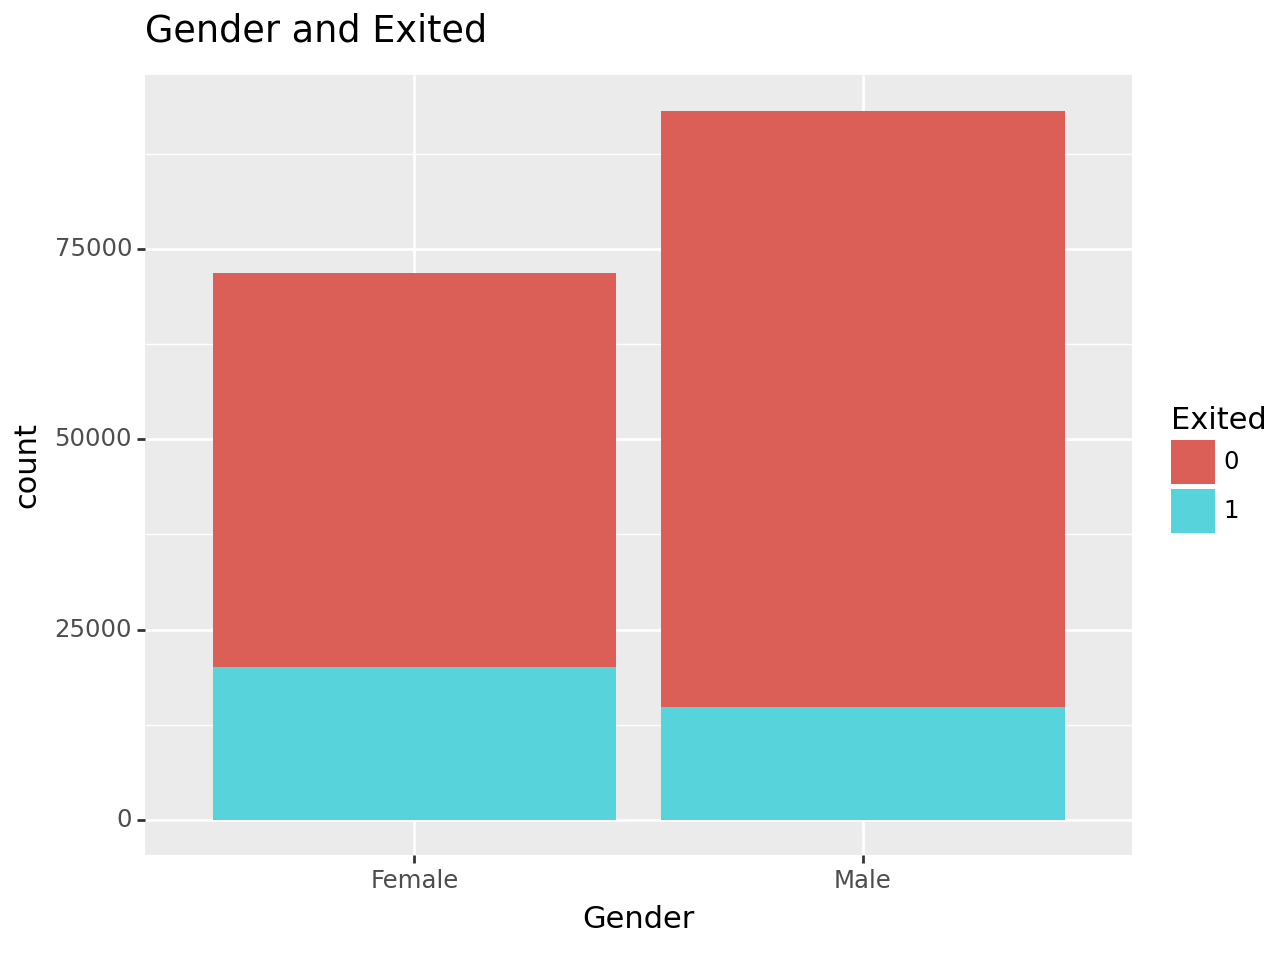

<Figure Size: (640 x 480)>

In [12]:
#Gender and Exited
y_target = train.Exited.apply(str)
d = gg.ggplot(data = train, mapping = gg.aes(x = train.Gender, fill = y_target))
d += gg.geom_bar()
d += gg.labs(title = "Gender and Exited")
# Apply encoding 1 for male, 0 for female
notes[4] = "Gender:  Apply encoding 1 for male, 0 for female"
d

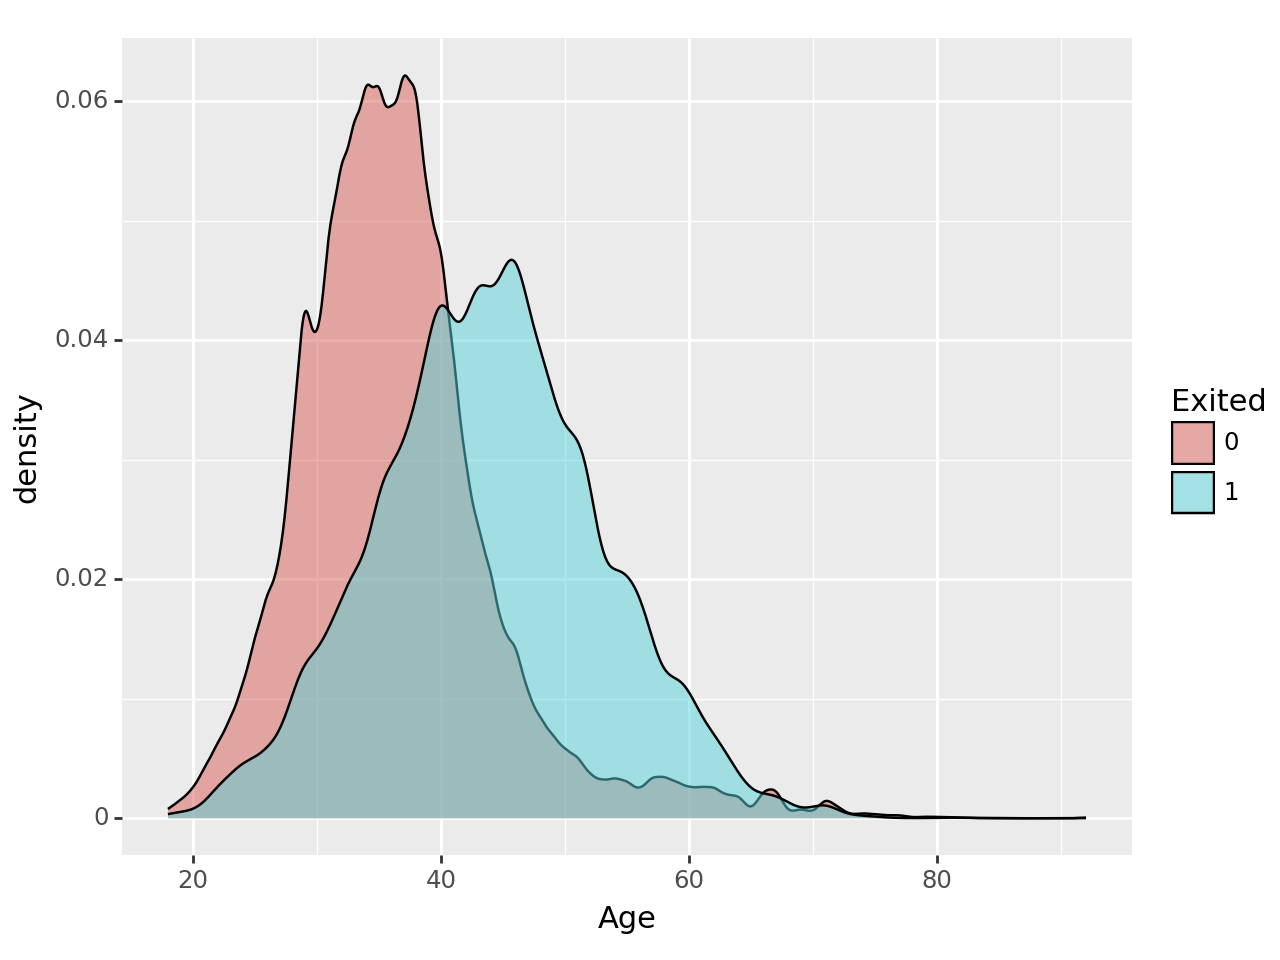

<Figure Size: (640 x 480)>

In [13]:
# Age and Exited
# boxplot first:
e = gg.ggplot(data = train, mapping = gg.aes(x = train.Age, fill = train.Exited.apply(str)))
e += gg.geom_density(alpha = 0.5)
#The cutting is in the age = 42 range
#Those who are older has a high probability of exiting
notes[5] ="Age: The cutting is in the age = 42 range"
notes[6] = "Age: Those who are older has a high probability of exiting."
e


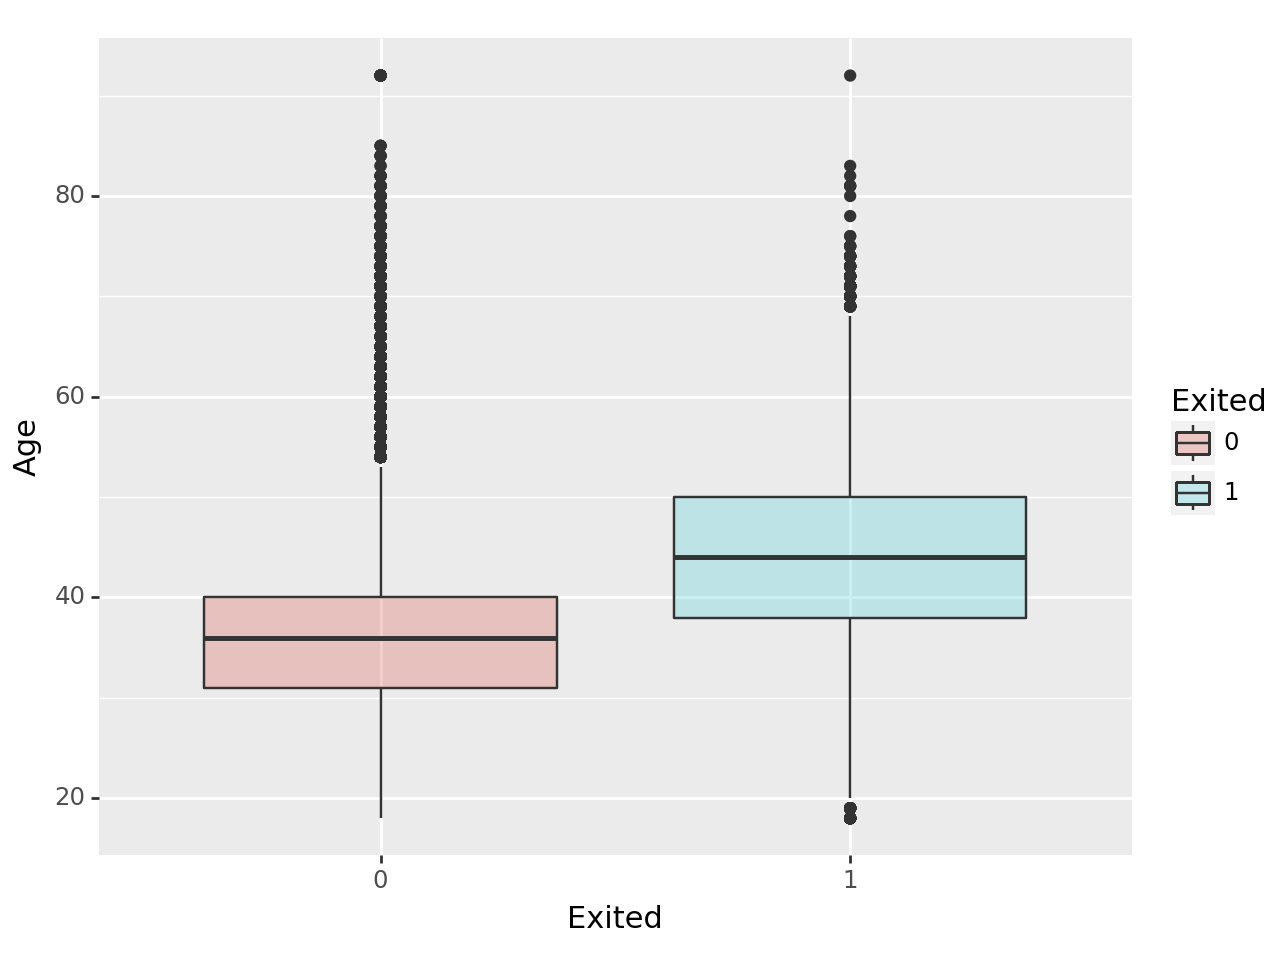

<Figure Size: (640 x 480)>

In [14]:
# Age and Exited
y_target = train.Exited.apply(str)
# boxplot first:
e = gg.ggplot(data = train, mapping = gg.aes(x = y_target, y = train.Age, fill = y_target))
e += gg.geom_boxplot(alpha = 0.3)
#The third quartile of exited = 0 and first quartile cut of exited = 1 are near to each other
notes[7] = "Age: The third quartile of exited = 0 and first quartile cut of exited = 1 are near to each other."
notes[8] = "Age: Log modify and do clustering"
e


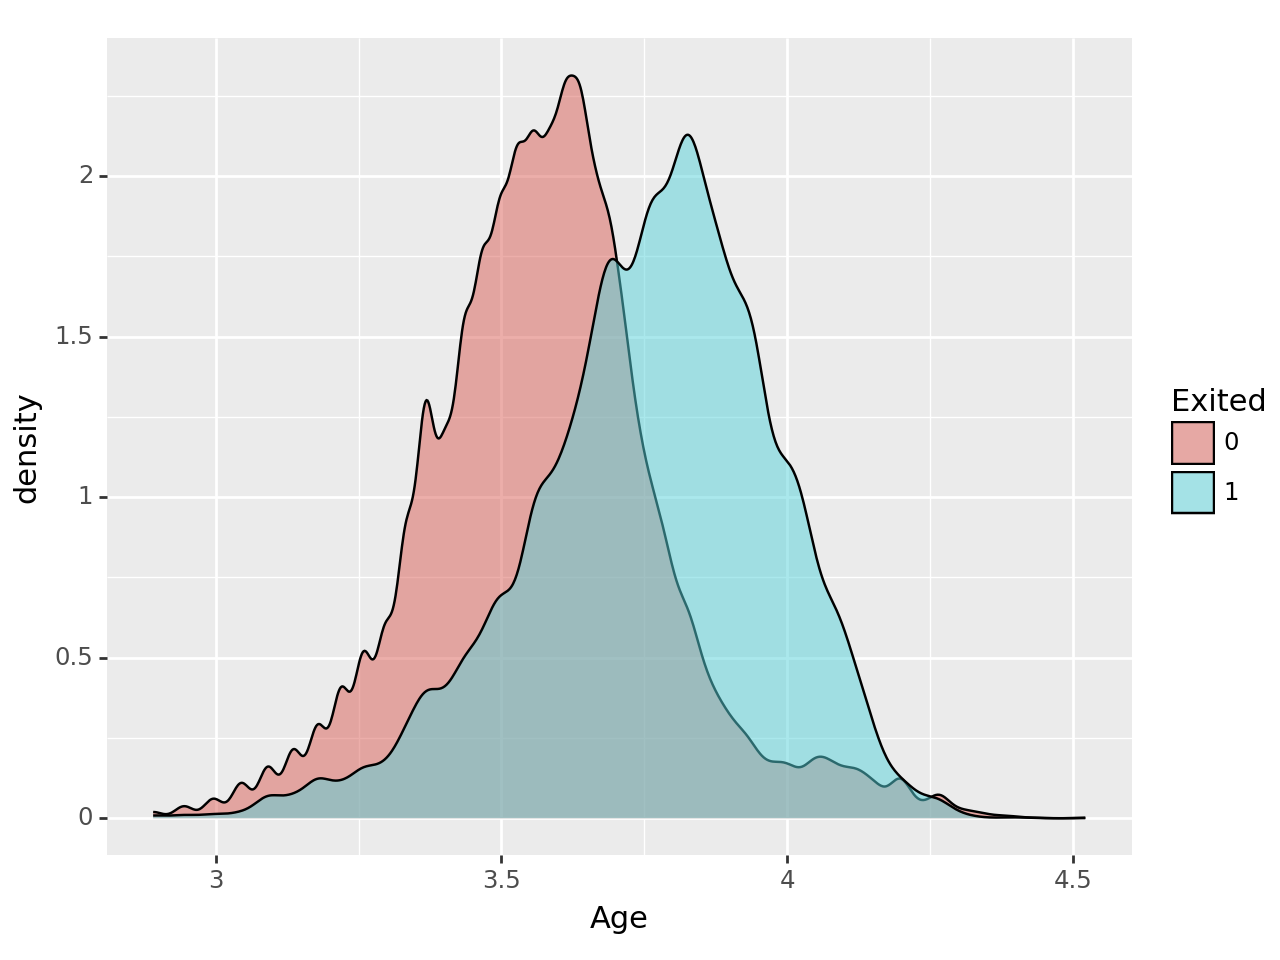

<Figure Size: (640 x 480)>

In [15]:
#Age and Exited. Log (Age)
# Age and Exited
# boxplot first:
e = gg.ggplot(data = train, mapping = gg.aes(x = np.log(train.Age), fill = train.Exited.apply(str)))
e += gg.geom_density(alpha = 0.5)
#The cutting is in the age = 42 range
#Those who are older has a high probability of exiting
notes[8] = "Age: When normalized, we can apply the z score transformation based on mean and sd of each type of Exited" 
e

In [16]:
# Apply a z score on log age:
def ageZScore(X,y):
    age_1 = pd.merge(np.log(X.Age), y, left_index = True, right_index = True)
    age_stats = age_1.groupby('Exited')['Age'].aggregate([('ave','mean'), ('std', 'std')])
    #put the z score:
    zero_age = X.Age.apply(lambda x: (np.log(x)-age_stats.iloc[0,0])/age_stats.iloc[0,1])
    one_age = X.Age.apply(lambda x: (np.log(x)-age_stats.iloc[1,0])/age_stats.iloc[1,1])
    return pd.DataFrame({'zero_age':zero_age, 'one_age': one_age}) 
    

In [17]:
age_z =  ageZScore(X,y)
age_z.head(3)

,zero_age,one_age
0,-0.379573,-1.237484
1,-0.379573,-1.237484
2,0.535729,-0.338092


In [18]:
age_cluster = KMeans(n_clusters = 2, n_init = 10)
age_cluster.fit(age_z.iloc[:,0:2])

KMeans(n_clusters=2, n_init=10)

In [19]:
age_z['cluster'] = age_cluster.predict(age_z.iloc[:,0:2])

In [20]:
age_z.head(8)

,zero_age,one_age,cluster
0,-0.379573,-1.237484,1
1,-0.379573,-1.237484,1
2,0.535729,-0.338092,0
3,-0.237533,-1.097913,1
4,-0.379573,-1.237484,1
5,0.034425,-0.830682,1
6,-0.833058,-1.683085,1
7,0.164789,-0.702584,0


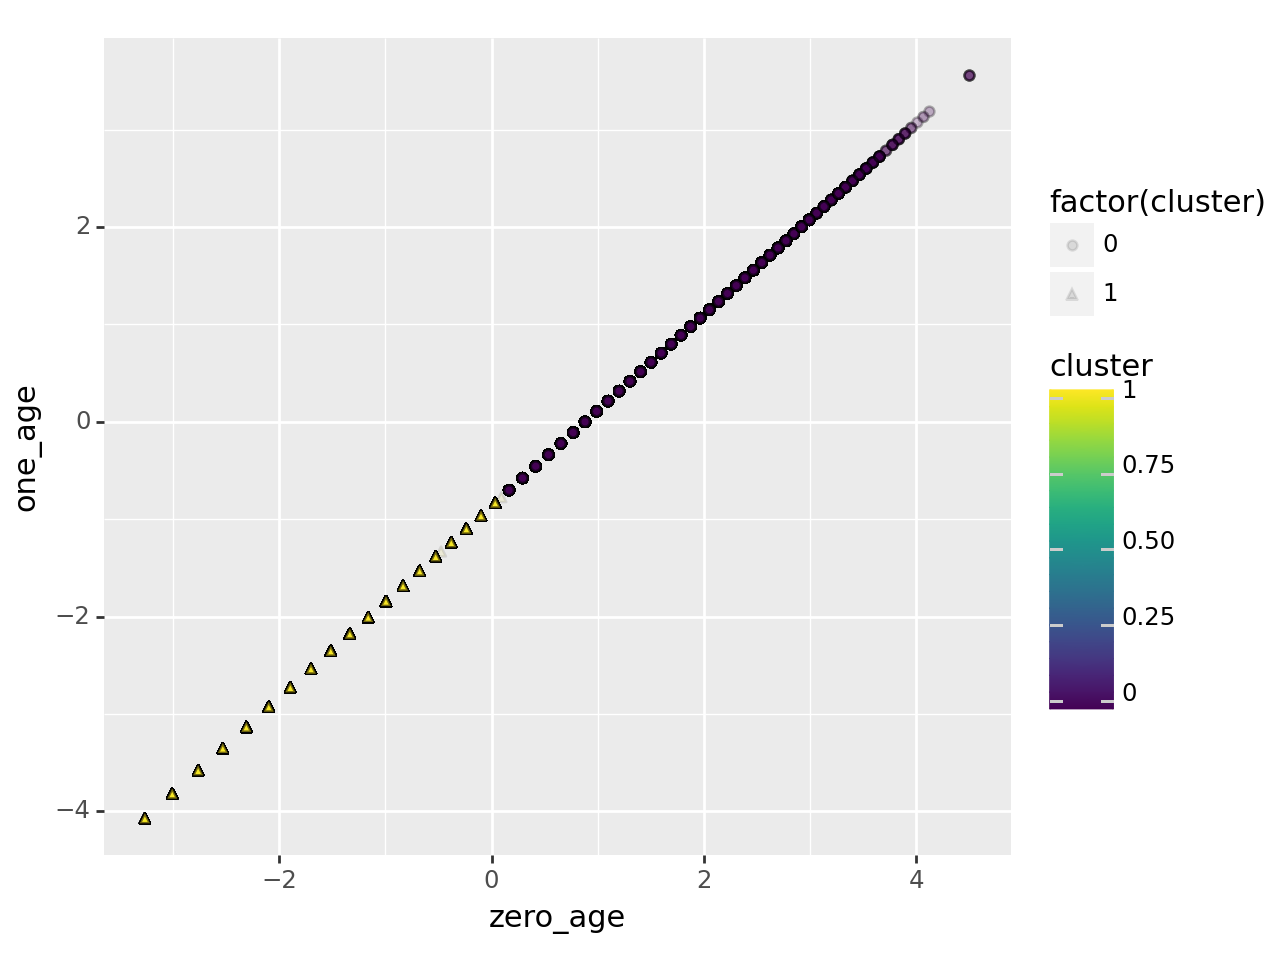

<Figure Size: (640 x 480)>

In [21]:
age_plot = gg.ggplot(data = age_z, mapping = gg.aes(x = 'zero_age', y = 'one_age', 
                                                   fill = 'cluster'))
age_plot += gg.geom_point(alpha = 0.1, mapping = gg.aes(shape = 'factor(cluster)'))
age_plot

In [22]:
# Tenure and Exited
print(train.Tenure.unique())
pd.crosstab(index = train.Exited, columns = train.Tenure)

[ 3  1 10  2  5  4  8  6  9  7  0]


Tenure,0,1,2,3,4,5,6,7,8,9,10
Exited,,,,,,,,,,,
0,3731,12970,14529,12820,13580,13468,12677,14469,14052,13165,4652
1,1276,3790,3516,3810,3974,3800,3145,3341,3468,3544,1257


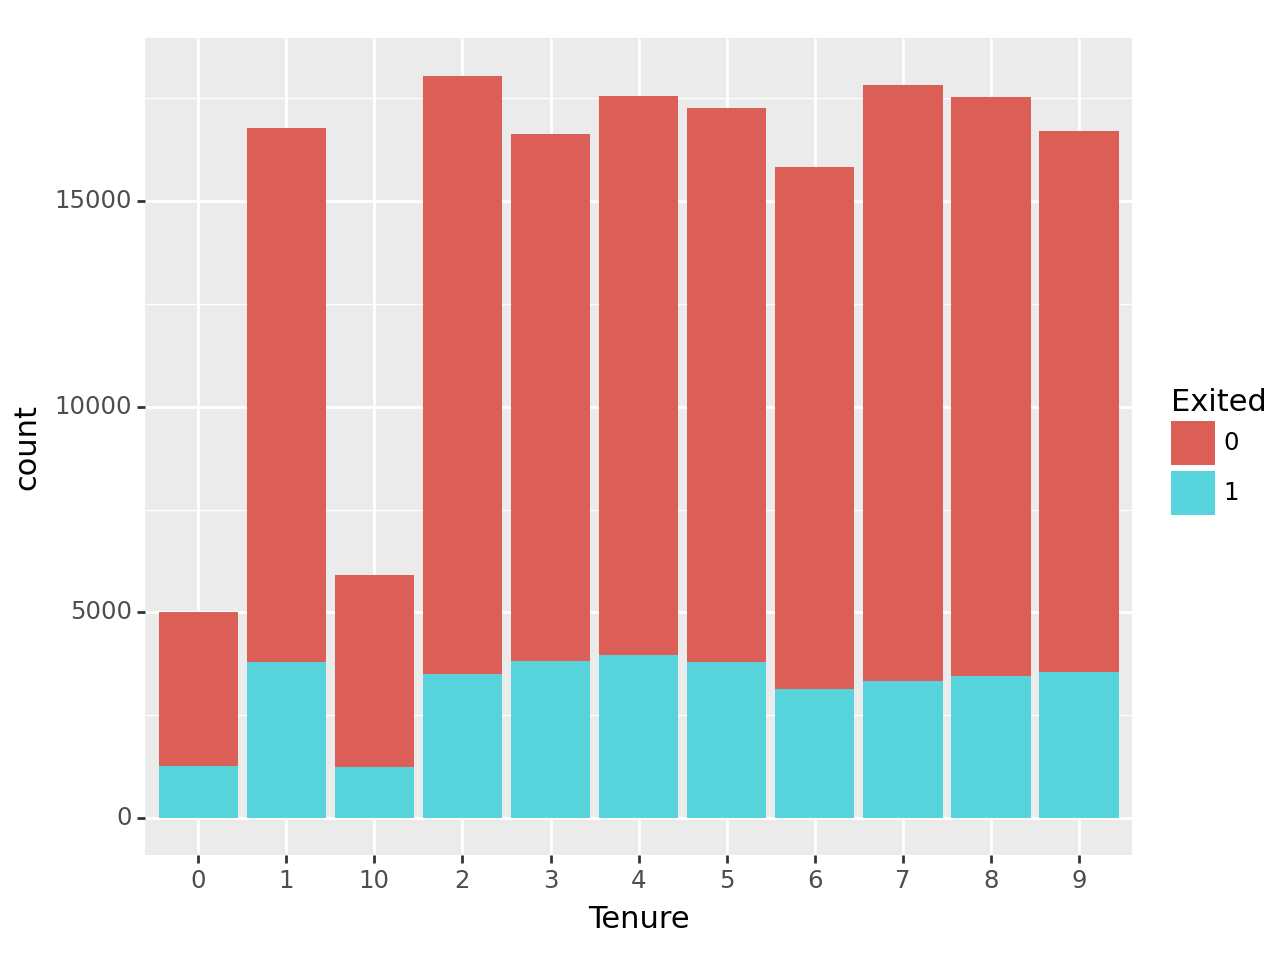

<Figure Size: (640 x 480)>

In [23]:
f = gg.ggplot(data = train, mapping = gg.aes(x = train.Tenure.apply(str), fill = train.Exited.apply(str)))
f += gg.geom_bar()
notes[9] = "Tenure: A one-hot-encoder should work here."
f
# A one-hot-encoder should work here.

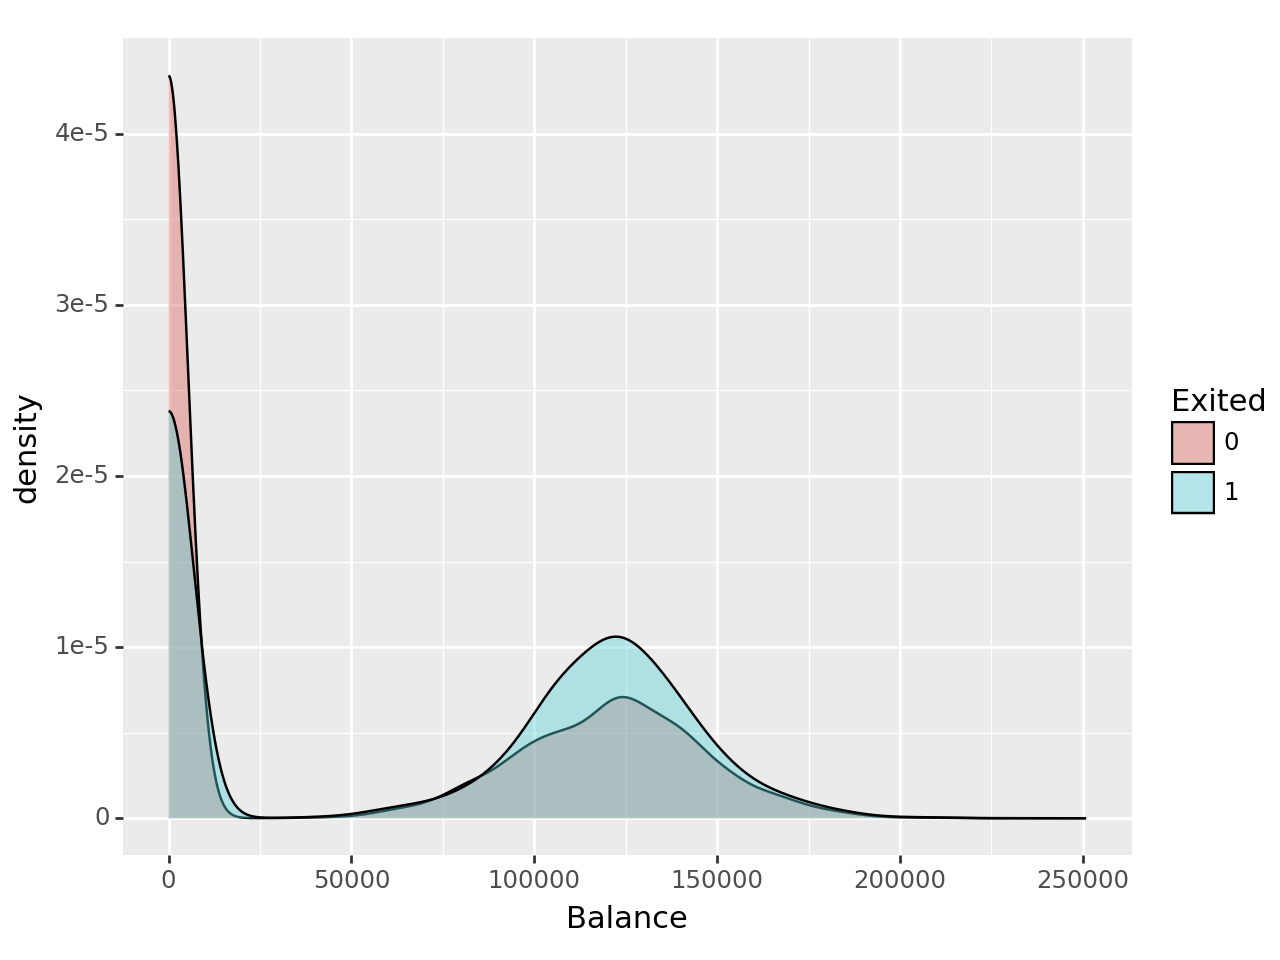

<Figure Size: (640 x 480)>

In [24]:
# Balance and exited
g = gg.ggplot(data = train, mapping = gg.aes(x = train.Balance, fill = train.Exited.apply(str)))
g += gg.geom_density(alpha = 0.4)
g

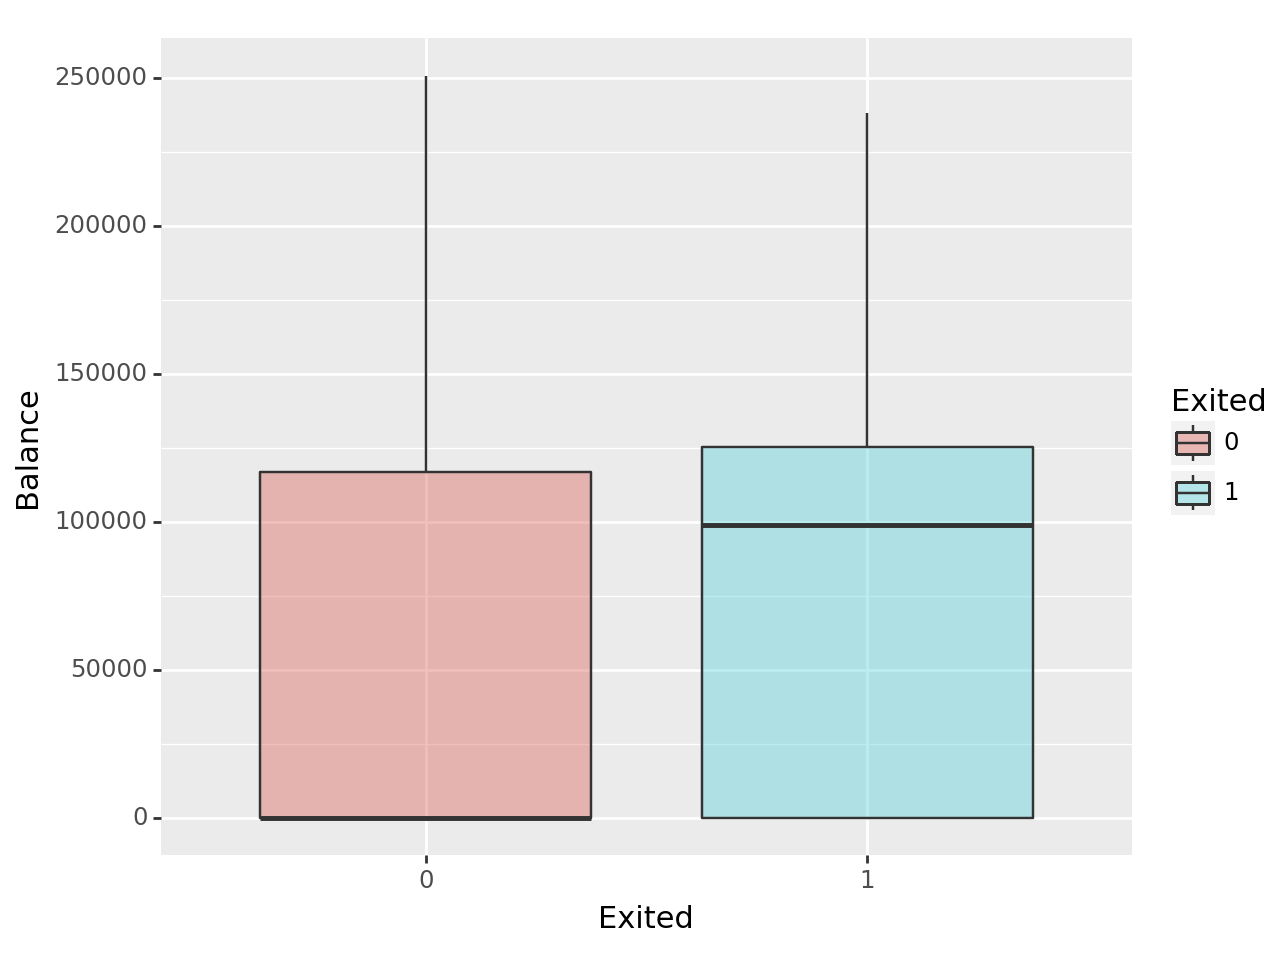

<Figure Size: (640 x 480)>

In [25]:
h = gg.ggplot(data = train, mapping = gg.aes(x = train.Exited.apply(str), y = train.Balance, 
                                             fill = train.Exited.apply(str)))
h += gg.geom_boxplot(alpha = 0.4)
notes[10] = "Balance: There is no relationship. Remove this."
h
#There is no relationship. Remove this.

Exited             0      1
NumOfProducts              
1              50516  26858
2              79198   5093
3                340   2554
4                 59    416


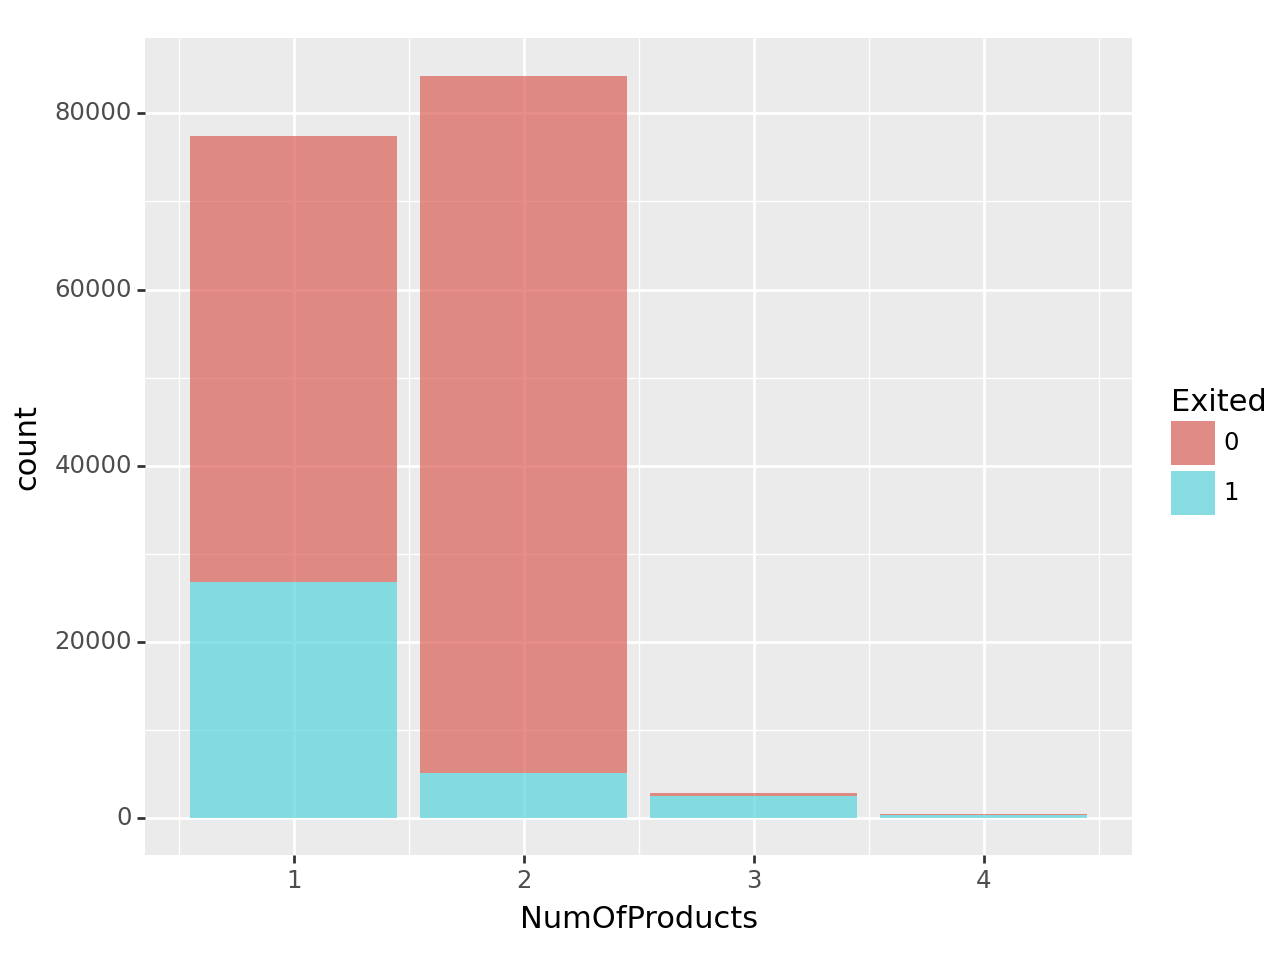

<Figure Size: (640 x 480)>

In [26]:
#Exited and NumOfProducts
i = gg.ggplot(data = train, mapping = gg.aes(x = train.NumOfProducts, fill = train.Exited.apply(str)))
i += gg.geom_bar(alpha = 0.7)
print(pd.crosstab(index = train.NumOfProducts, columns = train.Exited))
notes[11] = "NumOfProducts: Apply nothing here. Pass through "
i
#Apply nothing here. Pass through 

Exited         0      1
HasCrCard              
0.0        31371   9235
1.0        98742  25686


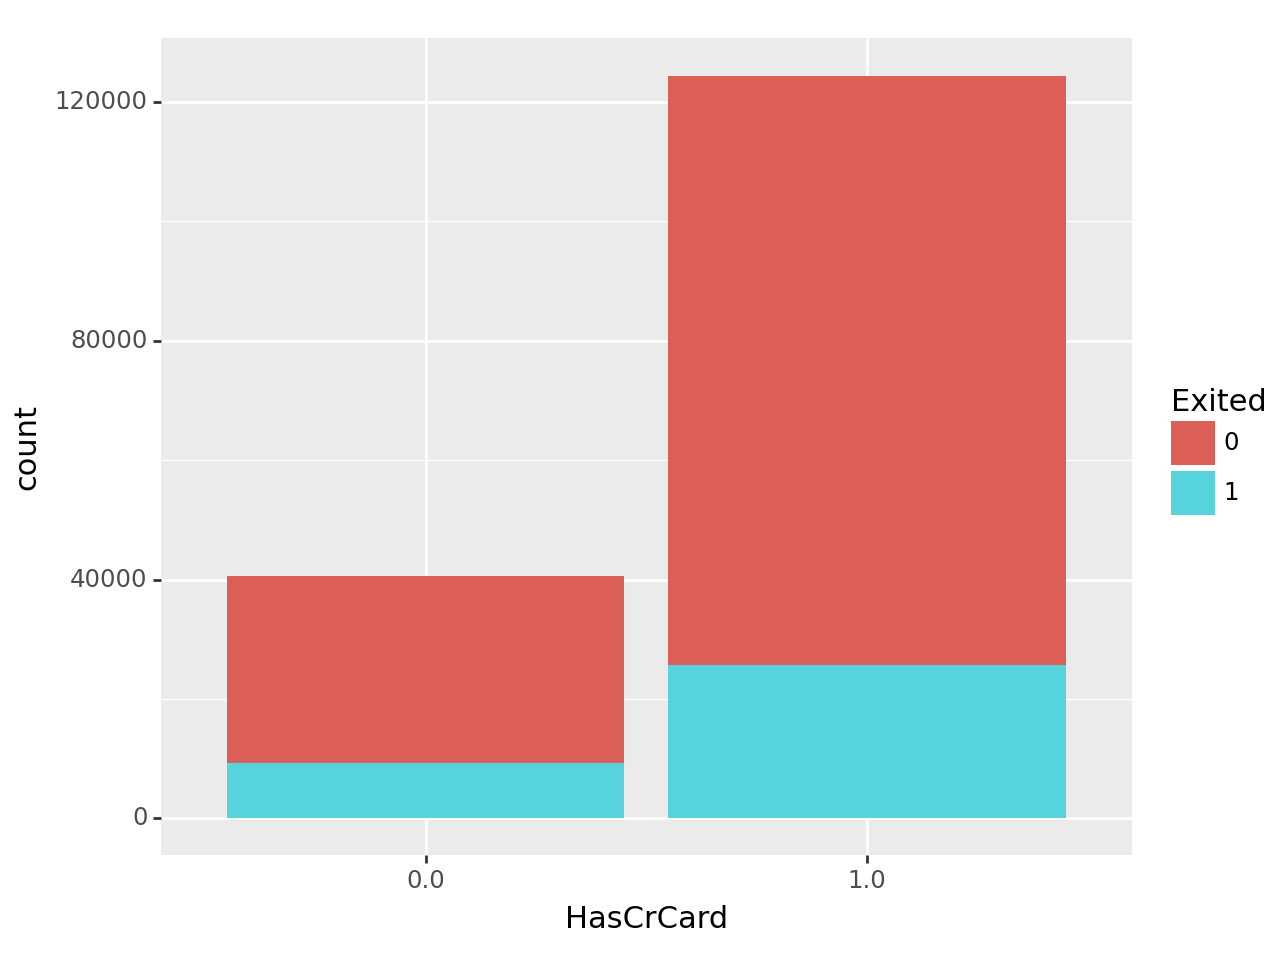

<Figure Size: (640 x 480)>

In [27]:
# HasCrCard and Exited
print(pd.crosstab(train.HasCrCard, train.Exited))
j = gg.ggplot(data = train, mapping = gg.aes(x = train.HasCrCard.apply(str), fill = train.Exited.apply(str)))
j += gg.geom_bar()
notes[12] = "HasCrCard: Do not do transformation. Pass through"
j
#do not do transformation. Pass through

Exited         0      1
HasCrCard              
0.0        31371   9235
1.0        98742  25686


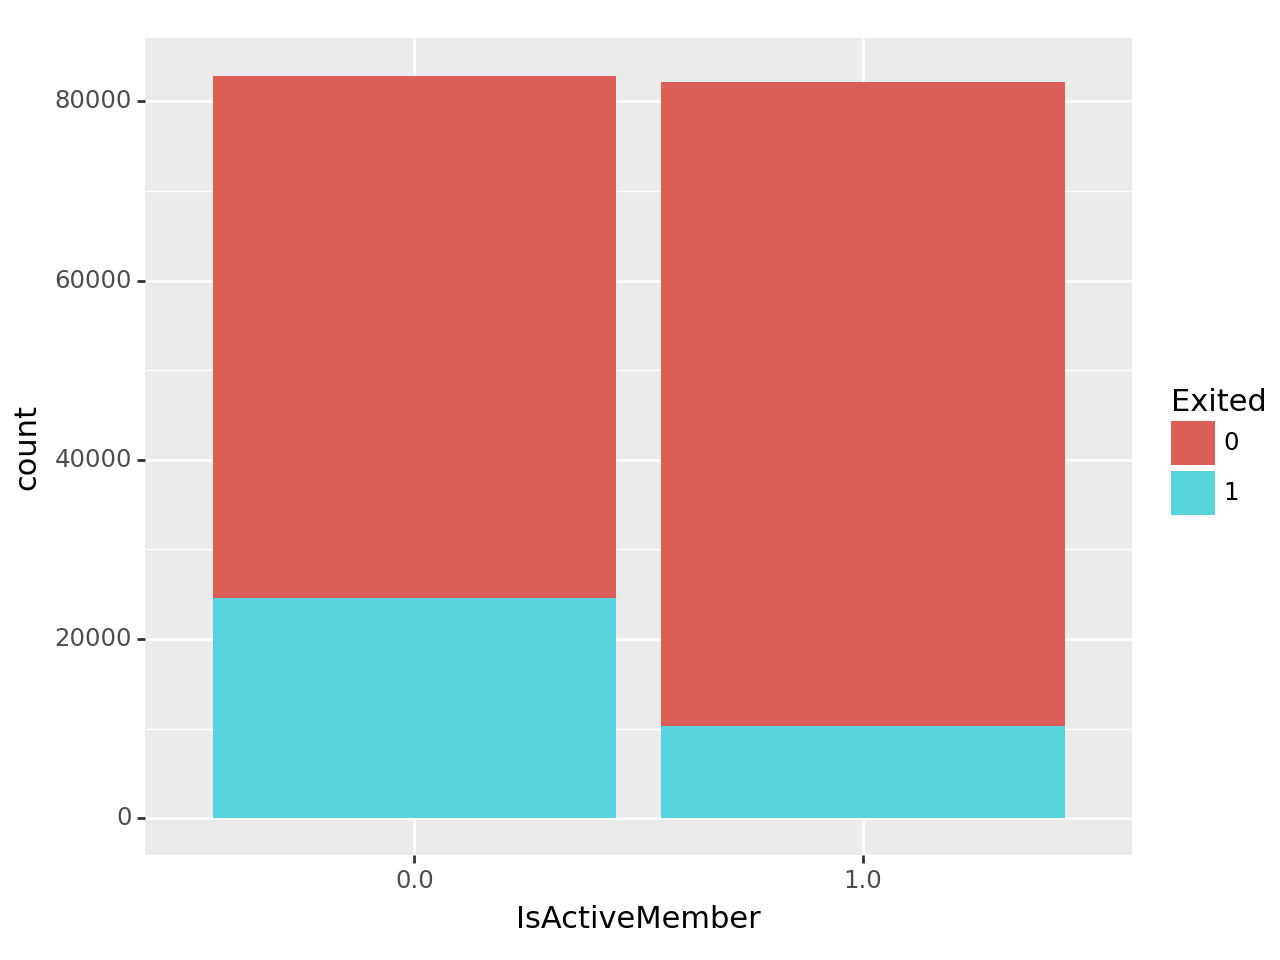

<Figure Size: (640 x 480)>

In [28]:
# IsActiveMember and Exited
print(pd.crosstab(train.HasCrCard, train.Exited))
k = gg.ggplot(data = train, mapping = gg.aes(x = train.IsActiveMember.apply(str), fill = train.Exited.apply(str)))
k += gg.geom_bar()
notes[13] = "IsActiveMember: do not do transformation. Pass through."
k
#do not do transformation. Pass through

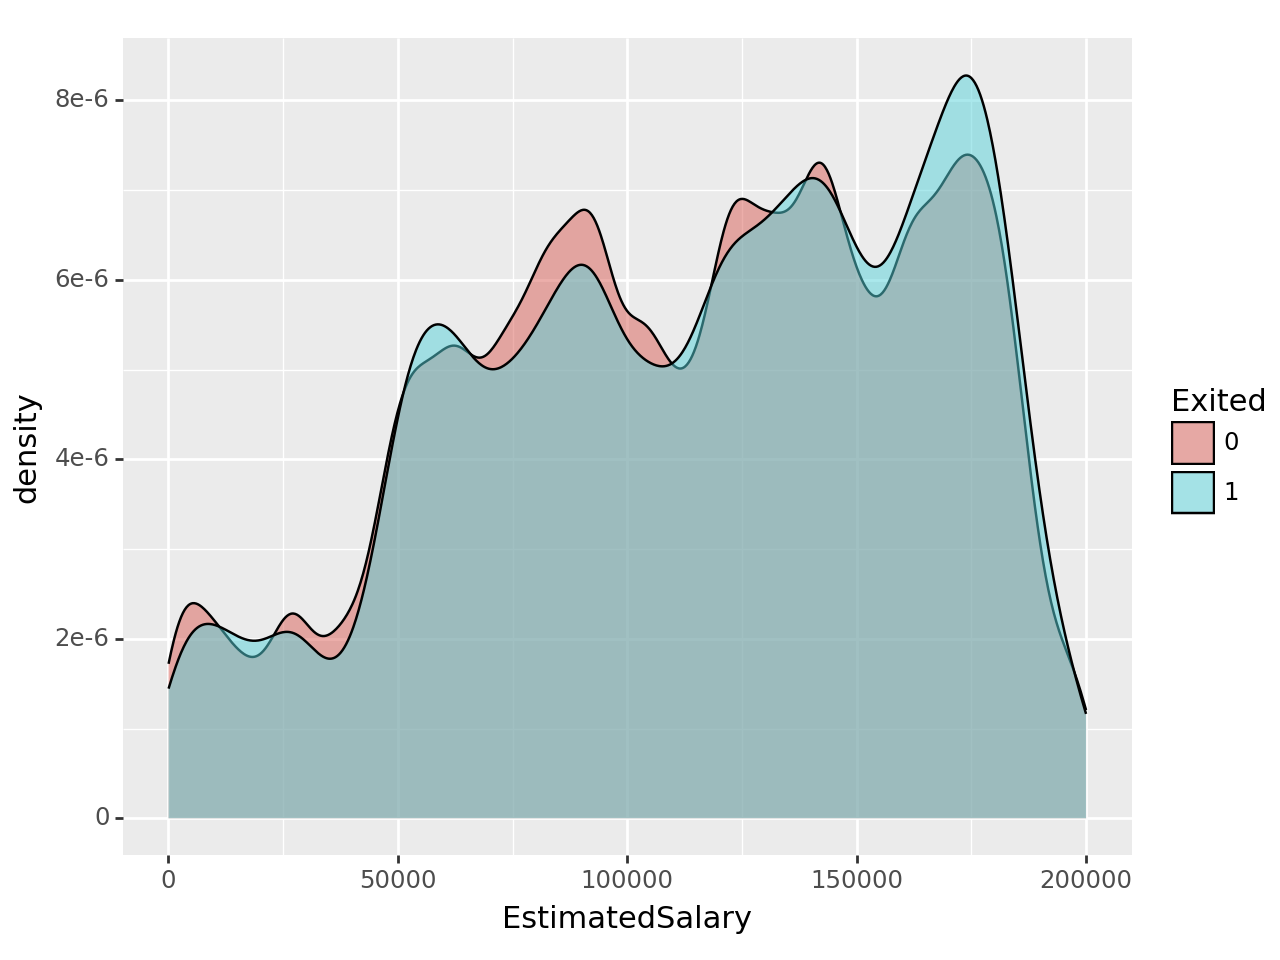

<Figure Size: (640 x 480)>

In [29]:
#Estimated Salary
l = gg.ggplot(data = train, mapping = gg.aes(x = train.EstimatedSalary, fill = train.Exited.apply(str)))
l += gg.geom_density(alpha = 0.5)
l
#Nothing Here. drop

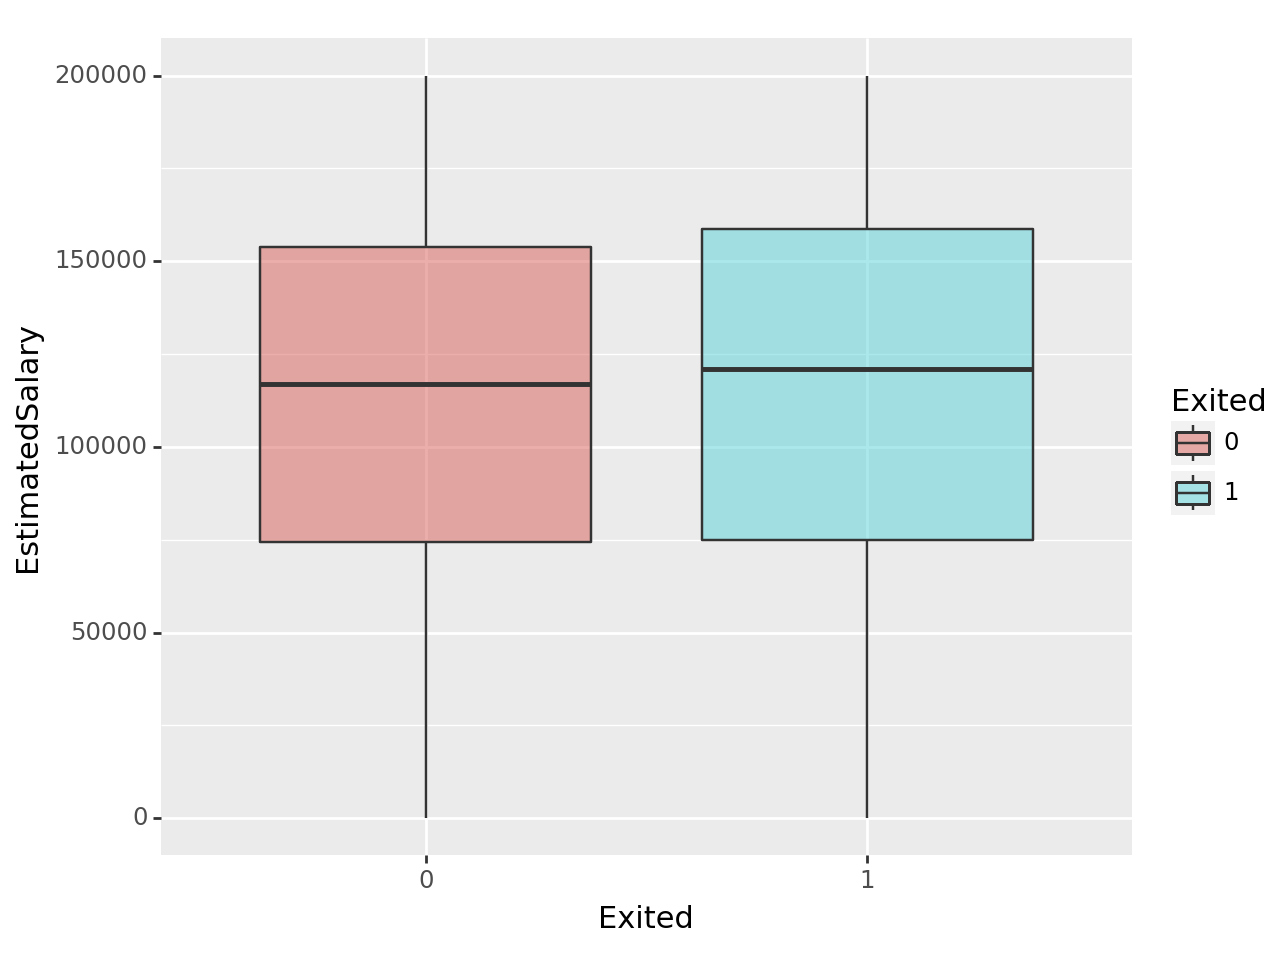

<Figure Size: (640 x 480)>

In [30]:
#Estimated Salary
exited = train.Exited.apply(str)
l = gg.ggplot(data = train, mapping = gg.aes(y = train.EstimatedSalary, x = exited, fill = exited))
l += gg.geom_boxplot(alpha = 0.5)
notes[14] = "EstimatedSalary : Drop. Nothing similar"
l
#Nothing Here. drop

In [31]:
#For Surname and CustomerId, apply TargetEncoder
notes[15] = "For Surname and CustomerId, apply TargetEncoder"

In [32]:
for k, n in notes.items():
    print(k, n)

1 for exited, use the ratio in optimizing XGBoost
2 No difference in credit score. Drop credit score. 
3 Geography and Exited:Use one hot encoder and remove the one variable
4 Gender:  Apply encoding 1 for male, 0 for female
5 Age: The cutting is in the age = 42 range
6 Age: Those who are older has a high probability of exiting.
7 Age: The third quartile of exited = 0 and first quartile cut of exited = 1 are near to each other.
8 Age: When normalized, we can apply the z score transformation based on mean and sd of each type of Exited
9 Tenure: A one-hot-encoder should work here.
10 Balance: There is no relationship. Remove this.
11 NumOfProducts: Apply nothing here. Pass through 
12 HasCrCard: Do not do transformation. Pass through
13 IsActiveMember: do not do transformation. Pass through.
14 EstimatedSalary : Drop. Nothing similar
15 For Surname and CustomerId, apply TargetEncoder


In [33]:
train.columns

Index(['index', 'id', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

In [34]:
# Apply a z score on log age:
age_1 = pd.merge(train.Age, y, left_index = True, right_index = True)
age_stats = age_1.groupby('Exited')['Age'].aggregate([('ave','mean'), ('std', 'std')])
age_stats

,ave,std
Exited,,
0,36.560480,8.147944
1,43.958478,9.004380


In [35]:
class SimpleTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.geo_encoder = LabelEncoder()
        self.gender_encoder = LabelEncoder()
        self.target_encoder = TargetEncoder()

    def fit(self, X, y):
        self.geo_encoder.fit(X['Geography'])
        self.gender_encoder.fit(X['Gender'])
        return self

    def transform(self,X):
        kk = pd.DataFrame()
        kk['Geography'] = self.geo_encoder.transform(X['Geography'])
        kk['Gender']  = self.gender_encoder.transform(X['Gender'])
        nn = self.target_encoder.transform(X[['CustomerId', 'Surname']])
        # Return next time: 
        # kk['CustomerId'] = np.copy(nn[:,0])
        # kk['Surname'] = np.copy(nn[:,1])
        kk['IsOld'] = X.Age.apply(lambda r: 1 if(r > 6) else 0)
        kk['isMiddleAge'] = X.age.apply(lambda r: 1 if (r > 42) else 0
        kk = pd.merge(kk, X[['Age','Tenure', 'NumOfProducts','HasCrCard','IsActiveMember']].copy(), 
                      right_index = True, left_index = True)
        #transform for age:
        return np.c_[np.array(kk)]



SyntaxError: '(' was never closed (3853447858.py, line 21)

In [ ]:
st = SimpleTransformer()
st.fit(X.copy(), y)
train_processed = st.transform(X.copy())
test_processed = st.transform(test.copy())

In [ ]:
print(train_processed.shape)
print(test_processed.shape)

In [ ]:
joblib.dump(train_processed, "train_processed.pkl")
joblib.dump(test_processed, "test_processed.pkl")

In [ ]:
l = pd.DataFrame(train_processed)
l.head(4)